In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

#------------------------------------------
# Import modules
#------------------------------------------
import pickle
import unicodedata
from re import sub
import ngram
import collections
import sqlite3

#------------------------------------------
# Declare variable
#------------------------------------------
directory_path = "./data/" # path to the corpus directory

In [2]:
#------------------------------------------
# Create ngram data
# for training : create sample ngram frequency as reference in DB
#------------------------------------------

""" Read listing data
Argument: file name
Return: dictionary
ex. {'ENG': ['2-5'...], 'TRK': ['3-1'...]} {'ENG': ['2-14'...], 'TRK': ['3-24'...]}
"""
def getListing(file):
    with open(directory_path+file, 'rb') as p:
        return pickle.load(p)
    
""" Make ngram list in descending order for each language and entire database
Argument1: file dictionary
Argument2: category name (train/test)
Return: dictionary of 2-7 grams list for each language
ex)
{'ENG': [('in', 0.63), ('and', 0.235)...], 'TRK': [('ar', 1.0),('lar', 0.392)...]}
"""
def  makeSample(index):
    all_list = {} # put ngrams 
    n = 3
    ngp = ngram.NGram(N = n) # declare ngram processor
    for language, files in index.items(): # treat each index data by language
        csr.execute('CREATE TABLE IF NOT EXISTS %s (ngram string, frequency integer)' % language)
        q_insert = f"INSERT INTO {language} VALUES (?, ?)"
        ngram_list = [] # list to put in ngrams for each language
        for file in files: # treat text data  of each file in the index
            file_id = directory_path + file + ".txt"
            with open(file_id, "r", encoding='utf-8') as f:
                for line in f.readlines():
                    line = unicodedata.normalize('NFKC', line.strip()) # noramalize the text
                    line = sub("[_/\+\$\*&#©,\.\(\)\[\]\"0-9]", "", line.strip())       
                    for n_gram in ngp.ngrams(ngp.pad(line)): # for ngramed item
                        ngram_list.append(n_gram)
            counted_items = (list(filter(lambda t: t[1]>=1, 
                                         collections.Counter(ngram_list).most_common())))  # put ngrams in descending order
            highest_frequency = collections.Counter(ngram_list).most_common(1) # the most frequent ngram
            for gram, nb in counted_items:
                row = [gram, round(nb/highest_frequency[0][1], 3)] # divide frequency by the highest one
                csr.execute(q_insert, row)
                db.commit()

# executions
train_list = getListing("train.bin") # get train file data
db = sqlite3.connect(directory_path+"train3.db") # connection to DB
db.text_factory = str
csr = db.cursor()
makeSample(train_list) # save sample ngrams into DB
db.close() # close DB

In [3]:
#------------------------------------------
# Compare sample and test data
#------------------------------------------
""" Create test data
"""
def makeTestNgrams(file_id):
    test_dict = {}
    n_dict = {} # put ngrams
    with open(file_id, "r", encoding='utf-8') as f:
        for line in f.readlines():
            line = unicodedata.normalize('NFKC', line.strip()) # noramalize the text
            line = sub("[_/\+\$\*&#©,\.\(\)\[\]\"0-9]", "", line.strip())     
            for n in range (2, 8): # 2-7grams
                ngp = ngram.NGram(N = n) # declare ngram processor
                for n_gram in ngp.ngrams(ngp.pad(line)): # for ngramed item
                    n_dict.setdefault(n, []).append(n_gram)
    for n, gram in n_dict.items():
        counted_items = (list(filter(lambda t: t[1]>=1, 
                                     collections.Counter(gram).most_common())) ) # put ngrams in descending order
        highest_frequency = collections.Counter(gram).most_common(1) # the most frequent ngram
        for gram, nb in counted_items:
            test_dict[gram] = round(nb/highest_frequency[0][1], 3)
    return test_dict           

""" Calculate frequency diffrencies of test with each language sample
Argument: test frequency data in dictionary
Return: predicted language in string
"""
def calculateDifference(test_file):
    langs = ["ENG", "TRK","FRA"]
    distance = {}
    for lang in langs:
        samples = {}
        q_select = f"SELECT * FROM {lang}"
        csr.execute(q_select)
        for row in enumerate(csr): # ngram frequency data from DB
            samples[str(row[1][0])] = str(row[1][1])
        overlap = ({gram: abs(round(nb-float(samples.get(gram)), 3)) 
                    for gram, nb in test_file.items()
                    if gram in samples.keys()} ) # collect overlap ngrams  and calculate difference between sample
        distance[lang] = returnSum(overlap)
    closest = min(distance, key=distance.get) # pick up the smallest distance as text lang
    return closest

""" Calculate the sum of the differencies
Argument: ngram dictionary
Return: sum of the differencies as distance to each language
"""
def returnSum(myDict):   
    sum = 0
    for i in myDict: 
        sum = sum + myDict[i] 
    return sum

""" check each test file
Arument: test file data as dictionary
ex. {'ENG': ['2-5'...], 'TRK': ['3-1'...]} {'ENG': ['2-14'...], 'TRK': ['3-24'...]}
Return1: list of predicted languages
Return2: number of correct prediction
"""
def checkTest(test_index):
    real_lang = [] # real language class
    predictions = [] # lang with the closest distance
    results = {} # {language:number of correct prediction}
    for lang, files in test_index.items():
        results[lang] = 0
        for file in files: # get ngrams and compare with sample  
            real_lang.append(lang)
            test_dict = makeTestNgrams(directory_path + file + ".txt")
            prediction = calculateDifference(test_dict) # get the closest language
            predictions.append(prediction) # add the language to list
            if prediction == lang: # if the prediction matches to real class
                results[lang] = results.get(lang, 0) +1
    return results, predictions, real_lang

def calculatePrecision(results, predictions): 
    for lang in results:
        print("Precision {lang}: {score}".format(
            lang=lang,
            score=results[lang]/len([x for x in predictions if x == lang]))
            )

def calculateRecall(results, test_data):
    for lang in results:
        print("Recall {lang}: {score}".format(
            lang=lang,
            score=results[lang]/len(test_data.get(lang)))
            )


# Executions
db = sqlite3.connect(directory_path+"train3.db") # Connection to DB to read sample data
db.text_factory = str
csr = db.cursor()

test = getListing("test.bin") # get test file data
results, predictions, real_class = checkTest(test)
#print(f"results: {results}, predictions: {predictions}")
calculatePrecision(results, predictions)
calculateRecall(results, test)
    
db.close() # close database

Precision ENG: 1.0
Precision TRK: 0.5
Precision FRA: 0.5
Recall ENG: 1.0
Recall TRK: 0.14285714285714285
Recall FRA: 0.8571428571428571


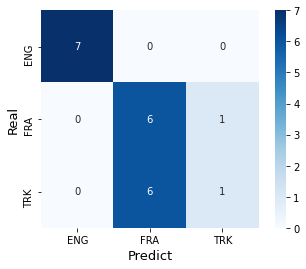

In [5]:
#------------------------------------------
#  Heatmap
#------------------------------------------

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#index =["ENG", "TRK", "FRA"]
index = sorted(list(set(real_class)))
cm = confusion_matrix(real_class, predictions)
cm = pd.DataFrame(data=cm, index=index, 
                           columns=index)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predict", fontsize=13, rotation=0)
plt.ylabel("Real", fontsize=13)
plt.savefig('sklearn_confusion_matrix3.png')